https://drive.google.com/file/d/1lmC2DQ4yzF0A88fzCEIeCw2HFuNK8yVF/view?usp=sharing


In [ ]:
from google.colab import files
import zipfile
import os
from google.colab import drive

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchsummary import summary

import numpy as np

from PIL import Image

from IPython.display import display

import cv2

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Cat semantic


In [ ]:
data = zipfile.ZipFile('/content/drive/MyDrive/cat_dataset.zip','r')
data.extractall('/dataset')
data.close()

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import cv2
import numpy as np
from torchvision.models.segmentation import fcn_resnet50
import torchvision.transforms.functional as FF
from torchvision.transforms.functional import convert_image_dtype

In [ ]:
paths=[]
for dirname, _, filenames in os.walk('/dataset/cat_dataset/'):
    for filename in filenames:
        paths+=[os.path.join(dirname, filename)]

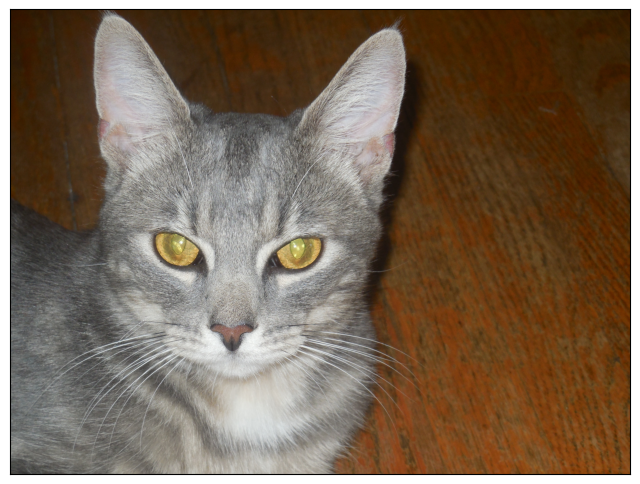

In [ ]:
img0=cv2.imread(paths[10])
plt.figure(figsize=(8,8))

plt.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False)

plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.show()

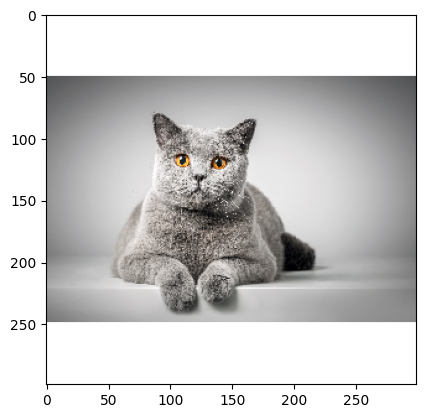

In [ ]:
def resize_image(input_path,target_size=(299, 299)):
    img = cv2.imread(input_path)

    height, width, _ = img.shape

    max_dimension = max(height, width)

    padded_img = np.full((max_dimension, max_dimension, 3), (255, 255, 255), dtype=np.uint8)

    x_offset = (max_dimension - width) // 2
    y_offset = (max_dimension - height) // 2

    padded_img[y_offset:y_offset+height, x_offset:x_offset+width, :] = img

    resized_img = cv2.resize(padded_img, target_size)
    return resized_img
img0=resize_image(paths[20])
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
from torchvision.models.segmentation import fcn_resnet50
model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
img1 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
cat_img = transform(img1)
# grid = make_grid([cat_img])
# show(grid)

In [ ]:
batch_int = torch.stack([cat_img])
batch = convert_image_dtype(batch_int, dtype=torch.float)

normalized_batch = FF.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 299, 299]) -5.265901565551758 14.289953231811523


shape = torch.Size([1, 299, 299]), dtype = torch.bool


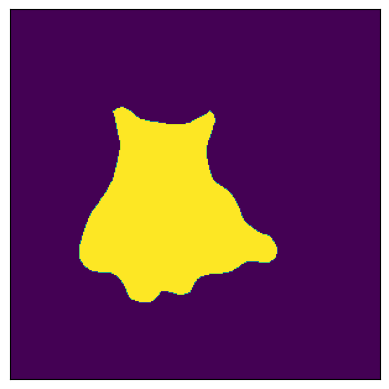

In [ ]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
normalized_masks = torch.nn.functional.softmax(output, dim=1)
class_dim = 1
boolean_cat_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['cat'])
print(f"shape = {boolean_cat_masks.shape}, dtype = {boolean_cat_masks.dtype}")
show([m.float() for m in boolean_cat_masks])

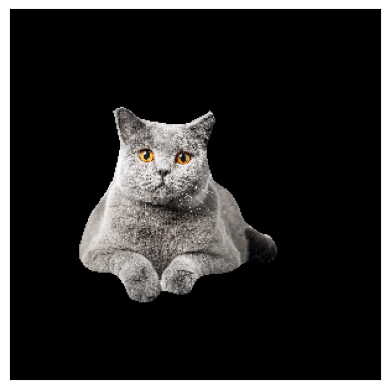

In [ ]:
cat_with_mask = boolean_cat_masks*cat_img
show(cat_with_mask)

In [ ]:
def semantic(input_path):
    resized_img = resize_image(input_path)
    cat_img = transform(resized_img)
    batch_int = torch.stack([cat_img])
    batch = convert_image_dtype(batch_int, dtype=torch.float)

    normalized_batch = FF.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    output = model(normalized_batch)['out']

    sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]
    sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
    normalized_masks = torch.nn.functional.softmax(output, dim=1)
    class_dim = 1
    boolean_cat_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['cat'])
    output_img = boolean_cat_masks*cat_img
    return output_img

def semantic_all_train_image(input_folder,output_folder):
    if not os.path.exists(output_folder):
      os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Check if the file is an image
        if os.path.isfile(input_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # try:
                output_img = semantic(input_path)
                numpy_image = (output_img.numpy() * 255).astype(np.uint8)

                # Convert from RGB to BGR (OpenCV uses BGR by default)
                bgr_image = cv2.cvtColor(numpy_image.transpose(1, 2, 0), cv2.COLOR_RGB2BGR)

                filename = os.path.basename(input_path)
                output_path = os.path.join(output_folder, f"resized_{filename}")
                cv2.imwrite(output_path, bgr_image)
                print(f"Padded, resized, and saved {filename} to {output_path}")
            # except Exception as e:
            #     print(f"Error processing {filename}: {e}")



In [ ]:
input_folder = "/dataset/cat_dataset/"
output_foler = "/dataset/cat_semantic_dataset/"
class_name = ["bengal","domestic_shorthair","maine_coon","ragdoll","siamese"]

for i in class_name:
    inp_pth = input_folder + i
    out_pth = output_foler + i
    #print(inp_pth)
    semantic_all_train_image(inp_pth,out_pth)


In [ ]:
!zip -r /dataset/cat_semantic_dataset_zip.zip /dataset/cat_semantic_dataset

# InceptionV3 model

In [ ]:
data = zipfile.ZipFile('/content/drive/MyDrive/cat_semantic_dataset_zip.zip','r')
data.extractall('/dataset')
data.close()

In [ ]:
def bgr_to_rgb_pil(x):
    b, g, r = x.split()
    im = Image.merge("RGB", (r, g, b))
    return im

data_transform = transforms.Compose([
        transforms.Lambda(bgr_to_rgb_pil),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomRotation((-180,180)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
])

dataset = datasets.ImageFolder(
    root = '/dataset/dataset/cat_semantic_dataset',
    transform = data_transform
)

batch_size = 16

total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size

generator = torch.Generator()
generator.manual_seed(0)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(total_size)

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    break

for X, y in val_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

951
Shape of X [N, C, H, W]: torch.Size([16, 3, 299, 299])
Shape of y: torch.Size([16]) torch.int64
tensor([2, 3, 4, 3, 1, 0, 4, 3, 4, 0, 1, 2, 0, 2, 1, 2])
Shape of X [N, C, H, W]: torch.Size([16, 3, 299, 299])
Shape of y: torch.Size([16]) torch.int64
Shape of X [N, C, H, W]: torch.Size([16, 3, 299, 299])
Shape of y: torch.Size([16]) torch.int64


torch.Size([3, 299, 299])

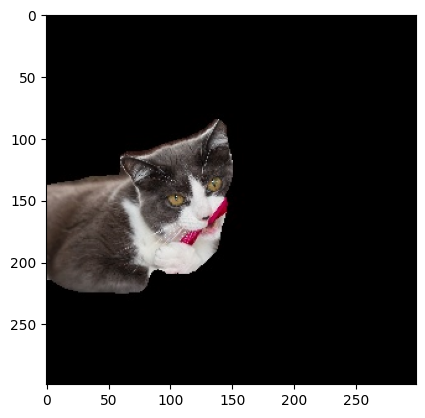

In [ ]:
i = 100
plt.imshow(train_dataset[i][0].permute(1, 2, 0))
train_dataset[i][0].shape

In [ ]:
# class FinetuneInceptionV3(nn.Module):
#     def __init__(self, num_classes):
#         super(FinetuneInceptionV3, self).__init__()

#         self.model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

#         self.model.aux_logits = False
#         for param in self.model.parameters():
#             param.requires_grad = False
#         self.fc = nn.Sequential(
#             nn.Linear(self.model.fc.in_features, 1024),
#             nn.Linear(1024, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)

#model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
#model = FinetuneInceptionV3(5).to(device)
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

The model will be running on cpu device


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model.aux_logits = False
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10,5)
)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 5)
# )

In [ ]:
model = model.cuda()
summary(model, (3, 299, 299))

RuntimeError: ignored

In [ ]:
loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%,  Avg loss: {test_loss:>8f} \n")


def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(y,pred.argmax(1))
    test_loss /= num_batches
    correct /= size

    print(f"Val Accuracy: {(100*correct):>0.1f}%,  Avg loss: {test_loss:>8f} \n")

In [ ]:
num_epochs = 30
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss, optimizer)
    val(val_loader, model, loss)
print("Done!")

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

_model.fc = nn.Sequential(
    nn.Linear(_model.fc.in_features, 10),
    nn.Linear(10,5)
)

weights=torch.load("model.pth")
_model.load_state_dict(weights)
_model = _model.cuda()
print("Test accuracy")
test(test_loader, _model, loss)

# external weight

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

_model.fc = nn.Sequential(
    nn.Linear(_model.fc.in_features, 10),
    nn.Linear(10,5)
)

weights=torch.load("/content/drive/MyDrive/77p1-0p76-ln2048t10t5.pth")
_model.load_state_dict(weights)
_model = _model.cuda()
print("Test accuracy")
test(test_loader, _model, loss)